In [186]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/01_covid_hiv_data.csv")
print(df.shape)

(9064474, 23)


In [187]:
START_DATE = (6, 2018)
END_DATE = (12, 2022)

start_date_point = df[(df["month"] == START_DATE[0]) & (df["year"] == START_DATE[1])]["visit_date"].tolist()[0]
end_date_point = df[(df["month"] == END_DATE[0]) & (df["year"] == END_DATE[1])]["visit_date"].tolist()[-1]

df = df[(df["visit_date"] >= start_date_point) & (df["visit_date"] <= end_date_point)].reset_index()
print(df.shape)

all_months = []
for v in df[["month", "year"]].values:
    all_months += [tuple(v)]
all_months = set(all_months)

MONTHS_DICT = {}
i = 0
for y in sorted(set(df["year"].tolist())):
    for m in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
        if (m, y) not in all_months:
            continue
        MONTHS_DICT[(m, y)] = i
        i += 1

MONTHS_DICT_INV = {v: k for k, v in MONTHS_DICT.items()}

(7386896, 24)


In [188]:
def binarize_category(df, column, cat):
    y = [0]*len(df)
    for i, v in enumerate(df[column].tolist()):
        if v == cat:
            y[i] = 1
    return y


def cummulative_months(df):
    months = []
    for m, y in df[["month", "year"]].values:
        months += [MONTHS_DICT[(m, y)]]
    return months


def proportions_by_month(df, column, value):
    df = df[df["month"].notnull()]
    df = df[df["year"].notnull()]
    df = df[df[column] != -1]
    months = np.array(cummulative_months(df), dtype=int)
    bin_values = np.array(binarize_category(df, column, value), dtype=int)
    unique_months = np.array(sorted(set(months)), dtype=int)
    proportions = []
    counts = []
    for m in unique_months:
        mask = months == m
        count = np.sum(mask)
        counts += [count]
        proportions += [np.sum(bin_values[mask]) / count]
    df = pd.DataFrame({"month": unique_months, "count": counts, "proportion": proportions})
    df = df[df["proportion"].notnull()]
    first_point = []
    for p in proportions:
        if p > 0:
            first_point = p
            break
    avg_point = np.nanmean(proportions)
    df["proportion_relative_avg"] = 100 * (np.array(df["proportion"]) - avg_point) / avg_point
    df["proportion_relative_init"] = 100 * (np.array(df["proportion"]) - first_point) / first_point
    return df


def num_samples_by_month(df):
    df = df[df["month"].notnull()]
    df = df[df["year"].notnull()]
    months = np.array(cummulative_months(df), dtype=int)
    unique_months = np.array(sorted(set(months)), dtype=int)
    counts = []
    for m in unique_months:
        mask = months == m
        count = np.sum(mask)
        counts += [count]
    df = pd.DataFrame({"month": unique_months, "count": counts})
    df = df[df["count"].notnull()]
    counts = np.array(df["count"].tolist())
    first_point = 0
    for c in counts:
        if c > 0:
            first_point = c
            break
    avg_point = np.nanmean(counts)
    df["count_relative_avg"] = 100 * (np.array(df["count"]) - avg_point) / avg_point
    df["count_relative_init"] = 100 * (np.array(df["count"]) - first_point) / first_point
    return df

In [189]:
import collections

def legend_counts(df, column):
    df = df[df[column] != -1]
    values = [0, 1, 2, 3, 4, 5, 6, 7]
    subsets = collections.OrderedDict()
    for v in values:
        n = df[df[column] == v].shape[0]
        if n > 0:
            subsets[v] = n
    return subsets

In [190]:
import matplotlib.pyplot as plt


def legend_plot(ax, df, column, mapping, colors):
    df = df[df[column] != -1]
    if type(mapping) == list:
        mapping_dict = dict((r[0], r[1]) for r in mapping)
    else:
        mapping_dict = mapping
    counts = legend_counts(df, column)
    keys = sorted(counts.keys())
    for i, k in enumerate(keys):
        if (len(keys) == 2) and (k == 0):
            continue
        if k not in mapping_dict:
            continue
        ax.scatter(0.1, i+0.5, color=colors[i])
        text = f"{mapping_dict.get(k, str(k))}\nN={counts[k]} ({counts[k] / df.shape[0] * 100:.1f}%)"
        ax.text(0.3, i+0.5, text, va="center", ha="left", color="black")
    ax.set_xlim(0, 1)
    ax.set_ylim(6.5, -0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    ax.set_axis_off()


def covid_legend_plot(ax):
    y = [0, 1, 2, 3, 4, 5]
    ytexts = ["Pre-COVID", "Wave 1", "Wave 2", "Wave 3", "Wave 4"]
    cmap = ContinuousColorMap(cmap="spectral")
    cmap.fit([0, 4])
    col = cmap.transform([0, 1, 2, 3])
    alpha = 0.5
    for i, (yval, ytext) in enumerate(zip(y, ytexts)):
        if i == 0:
            col_ = colors.gray
        else:
            col_ = col[i-1]
        ax.add_patch(
            plt.Rectangle((0, i), 0.2, 1, facecolor=col_, label=ytext, edgecolor="white", lw=0, alpha=alpha)
        )
        ax.text(0.3, i + 0.5, ytext, va="center", ha="left", color="black")
    ax.plot([0, 0.2], [5.5, 5.5], color=colors.red, lw = 2)
    ax.text(0.3, 5.5, "Vaccine rollout", va="center", ha="left", color="black")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    ax.set_axis_off()


In [191]:
CD4_CUTOFFS = [
    (1, "<100"),
    (2, "100-349"),
    (3, "350-499"),
    (4, "500+")
]

RNA_CUTOFFS = [
    (1, "<60"),
    (2, "600-200"),
    (3, "200-999"),
    (4, "1000+")
]

RETENTION_CUTOFFS = [
    (0, "0 days"),
    (1, "1-6 days"),
    (2, "7-29 days"),
    (3, "30-89 days"),
    (4, "90-179 days"),
    (5, "180+ days")
]

WHO_STAGE_CUTOFFS = [
    (1, "Stage 1"),
    (2, "Stage 2"),
    (3, "Stage 3"),
    (4, "Stage 4")
]

In [192]:
results = [num_samples_by_month(df)]
for c in CD4_CUTOFFS:
    results += [proportions_by_month(df, "cd4", c[0])]
for c in RNA_CUTOFFS:
    results += [proportions_by_month(df, "rna", c[0])]
results += [proportions_by_month(df, "viremic", 1)]
for c in WHO_STAGE_CUTOFFS:
    results += [proportions_by_month(df, "who_stage", c[0])]
results += [proportions_by_month(df, "died", 1)]
for c in RETENTION_CUTOFFS:
    results += [proportions_by_month(df, "retention", c[0])]
results += [proportions_by_month(df, "retention", 5)]



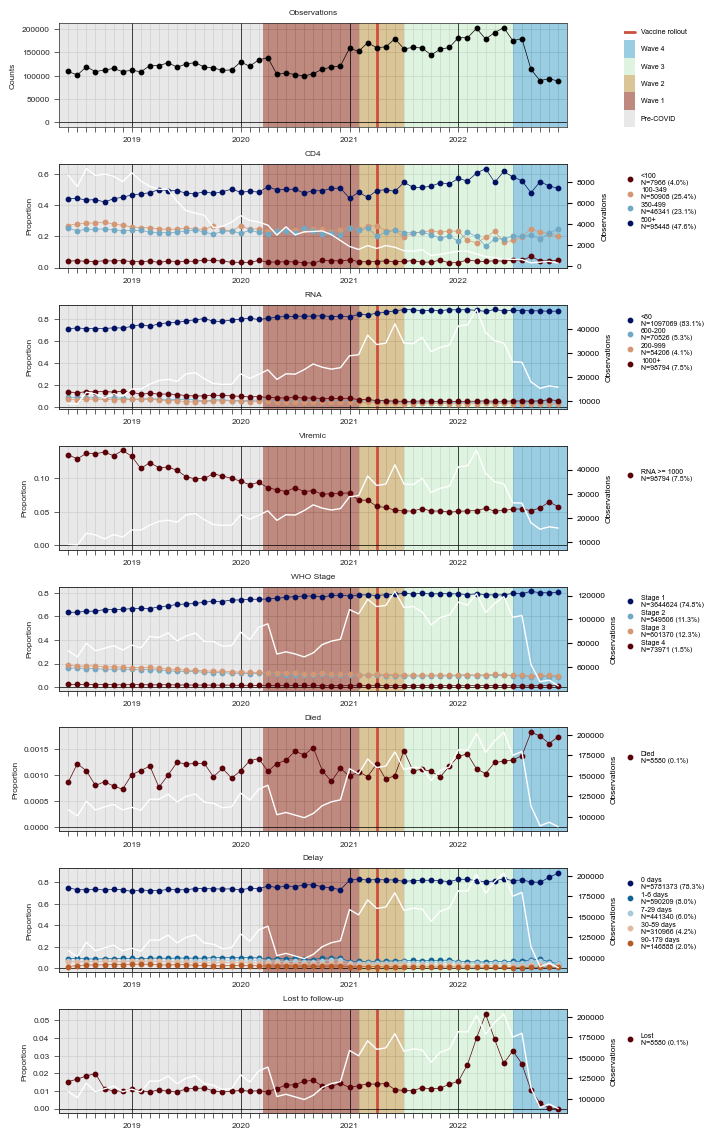

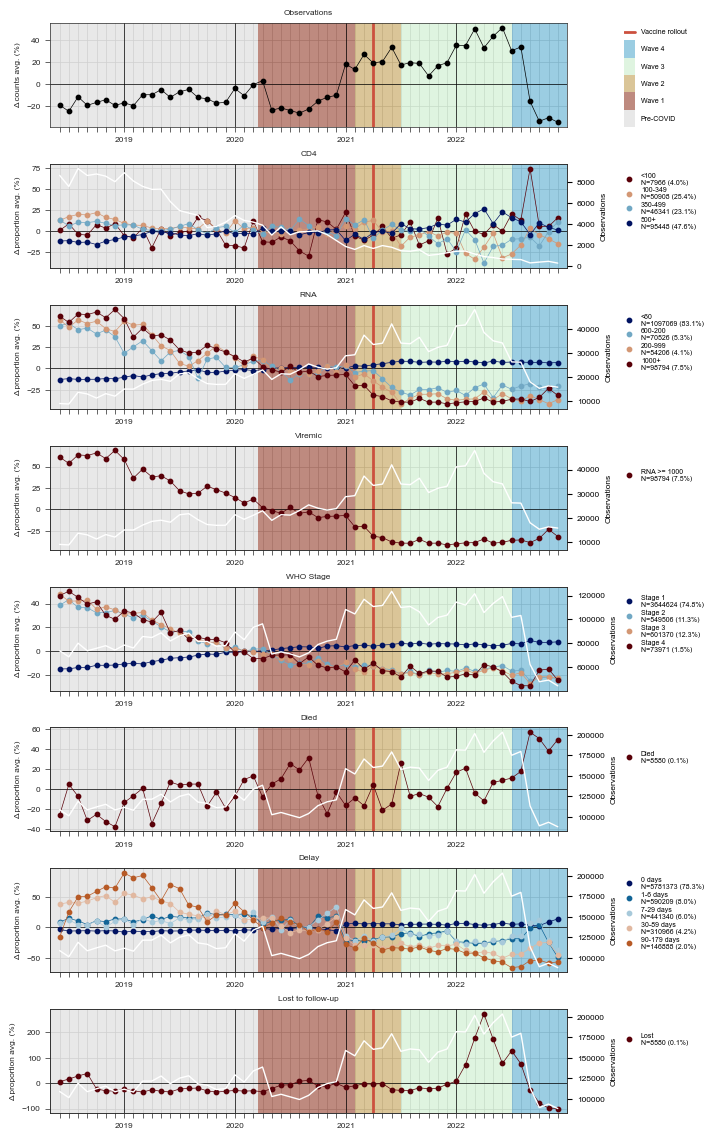

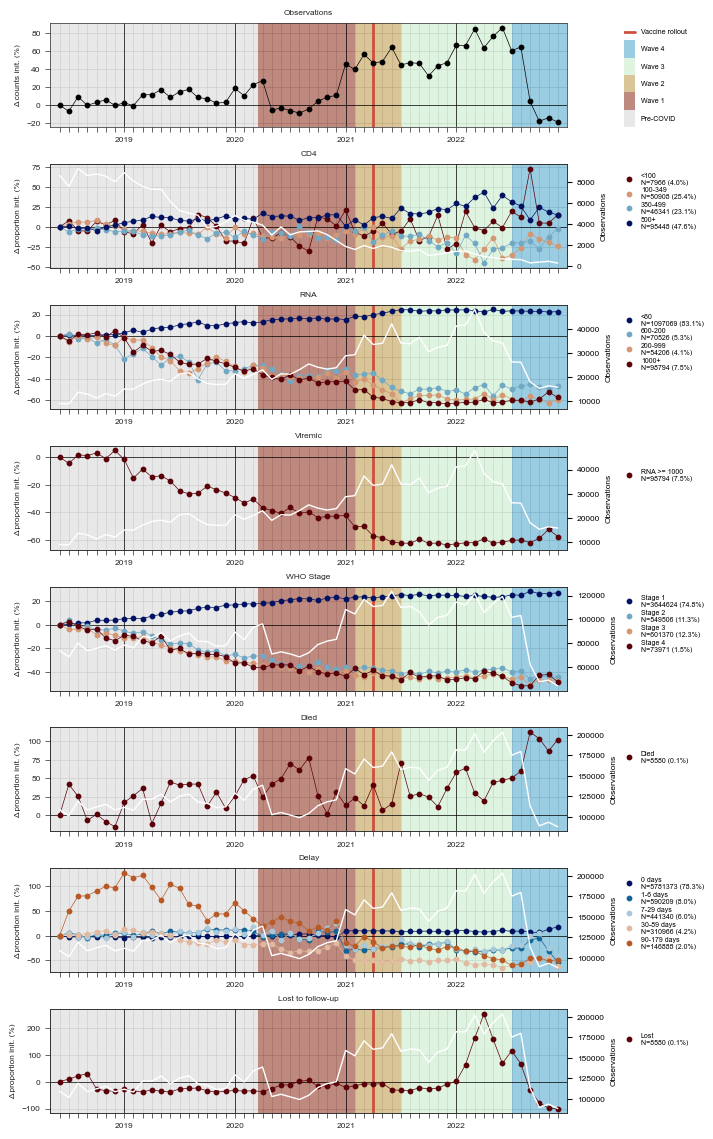

In [193]:
import stylia
import matplotlib.pyplot as plt

from stylia.colors.colors import NamedColors, ContinuousColorMap

cmap = ContinuousColorMap(cmap="coolwarm")
colors = NamedColors()

x_wave_1 = MONTHS_DICT[(3, 2020)] + 0.5
x_wave_2 = MONTHS_DICT[(2, 2021)]
x_wave_3 = MONTHS_DICT[(7, 2021)]
x_wave_4 = MONTHS_DICT[(7, 2022)]

vaccine = MONTHS_DICT[(4, 2021)]


def make_plots(name, mode):

    if mode not in [None, "default", "relative_avg", "relative_init"]:
        raise ValueError(f"Unknown mode: {mode}")

    if mode == "default":
        sufix = ""
        ylabel_counts = "Counts"
        ylabel_prop = "Proportion"
    elif mode == "relative_avg":
        sufix = "_relative_avg"
        ylabel_counts = "Δ counts avg. (%)"
        ylabel_prop = "Δ proportion avg. (%)"
    elif mode == "relative_init":
        sufix = "_relative_init"
        ylabel_counts = "Δ counts init. (%)"
        ylabel_prop = "Δ proportion init. (%)"

    y_col_counts = "count{0}".format(sufix)
    y_col_prop = "proportion{0}".format(sufix)

    def add_waves(ax):
        cmap = ContinuousColorMap(cmap="spectral")
        cmap.fit([0, 4])
        col = cmap.transform([0, 1, 2, 3])
        alpha = 0.5
        ax.axvspan(xmin-1, x_wave_1, facecolor = colors.gray, alpha = alpha, edgecolor="none")
        ax.axvspan(x_wave_1, x_wave_2, facecolor = col[0], alpha = alpha, edgecolor="none")
        ax.axvspan(x_wave_2, x_wave_3, facecolor = col[1], alpha = alpha, edgecolor="none")
        ax.axvspan(x_wave_3, x_wave_4, facecolor = col[2], alpha = alpha, edgecolor="none")
        ax.axvspan(x_wave_4, xmax+1, facecolor = col[3], alpha=alpha, edgecolor="none")
        ax.axvline(vaccine, color = colors.red, lw=2, label = "Vaccine rollout")
        for k,v in MONTHS_DICT.items():
            if k[0] == 1:
                ax.axvline(v, color = colors.black, lw=0.5)
        ax.axhline(0, color = colors.black, lw=0.5)

    def add_observations(ax, dp):
        ax2 = ax.twinx()
        ax2.plot(dp["month"], dp["count"], color = "white", lw=1, zorder = 1)
        ax2.set_ylabel("Observations", color="black")
        ax2.grid(False)
        ax2.tick_params(axis="y", colors="black")

    fig, axs = stylia.create_figure(8, 2, width = stylia.TWO_COLUMNS_WIDTH, height = stylia.TWO_COLUMNS_WIDTH*1.6, width_ratios = [0.9, 0.1])

    xmax = None
    xmin = None
    for dp in results:
        if xmax is None:
            xmax = dp["month"].max()
            xmin = dp["month"].min()
            continue
        xmax = max(xmax, dp["month"].max())
        xmin = min(xmin, dp["month"].min())

    xticks = [i for i in range(xmin, xmax + 1)]
    xticklabels = []
    for x in xticks:
        if x in MONTHS_DICT_INV:
            m, y = MONTHS_DICT_INV[x]
            if m == 1:
                xticklabels += [str(y)]
            else:
                xticklabels += [""]
        else:
            xticklabels += [""]

    idx_count = 0

    # Counts by month
    dp = results[idx_count]
    ax = axs.next()
    dp = num_samples_by_month(df)
    ax.plot(dp["month"], dp[y_col_counts], marker="o", color = colors.black, label="Visits", zorder=1000)
    add_waves(ax)
    stylia.label(ax, title = "Observations", xlabel = "", ylabel = ylabel_counts)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(xmin-1, xmax+1)
    idx_count += 1
    # Legend
    ax = axs.next()
    covid_legend_plot(ax)
    
    # CD4
    ax = axs.next()
    cmap.fit([i for i in range(len(CD4_CUTOFFS))])
    colors_list = cmap.transform([i for i in range(len(CD4_CUTOFFS))])
    colors_list = colors_list[::-1]
    i = 0
    for k,v in CD4_CUTOFFS:
        dp = results[idx_count]
        ax.plot(dp["month"], dp[y_col_prop], marker="o", label = v, color=colors_list[i], zorder=1000)
        i += 1
        idx_count += 1
    add_waves(ax)
    add_observations(ax, dp)
    stylia.label(ax, title = "CD4", xlabel = "", ylabel = ylabel_prop)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(xmin-1, xmax+1)
    # Legend
    ax = axs.next()
    legend_plot(ax, df, "cd4", CD4_CUTOFFS, colors_list)

    # RNA
    ax = axs.next()
    cmap.fit([i for i in range(len(RNA_CUTOFFS))])
    colors_list = cmap.transform([i for i in range(len(RNA_CUTOFFS))])
    i = 0
    for k,v in RNA_CUTOFFS:
        dp = results[idx_count]
        ax.plot(dp["month"], dp[y_col_prop], marker="o", label = v, color=colors_list[i], zorder=1000)
        i += 1
        idx_count += 1
    add_waves(ax)
    add_observations(ax, dp)
    stylia.label(ax, title = "RNA", xlabel = "", ylabel = ylabel_prop)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(xmin-1, xmax+1)
    # Legend
    ax = axs.next()
    legend_plot(ax, df, "rna", RNA_CUTOFFS, colors_list)

    # Viremic
    dp = results[idx_count]
    ax = axs.next()
    cmap.fit([0, 1])
    colors_list = cmap.transform([0,1])
    ax.plot(dp["month"], dp[y_col_prop], marker="o", color = colors_list[1], label = "RNA >= 1000", zorder=1000)
    add_waves(ax)
    add_observations(ax, dp)
    stylia.label(ax, title = "Viremic", xlabel = "", ylabel = ylabel_prop)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(xmin-1, xmax+1)
    idx_count += 1
    # Legend
    ax = axs.next()
    legend_plot(ax, df, "viremic", {0: "RNA < 1000", 1: "RNA >= 1000"}, colors_list)

    # WHO Stage
    ax = axs.next()
    cmap.fit([i for i in range(len(WHO_STAGE_CUTOFFS))])
    colors_list = cmap.transform([i for i in range(len(WHO_STAGE_CUTOFFS))])
    i = 0
    for k,v in WHO_STAGE_CUTOFFS:
        dp = results[idx_count]
        ax.plot(dp["month"], dp[y_col_prop], marker="o", label = v, color=colors_list[i], zorder=1000)
        i += 1
        idx_count += 1
    add_waves(ax)
    add_observations(ax, dp)
    stylia.label(ax, title = "WHO Stage", xlabel = "", ylabel = ylabel_prop)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(xmin-1, xmax+1)
    # Legend
    ax = axs.next()
    legend_plot(ax, df, "who_stage", WHO_STAGE_CUTOFFS, colors_list)

    # Died
    dp = results[idx_count]
    ax = axs.next()
    cmap.fit([0, 1])
    colors_list = cmap.transform([0,1])
    ax.plot(dp["month"], dp[y_col_prop], marker="o", color = colors_list[1], label="Died", zorder=1000)
    stylia.label(ax, title = "Died", xlabel = "", ylabel = ylabel_prop)
    add_waves(ax)
    add_observations(ax, dp)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(xmin-1, xmax+1)
    idx_count += 1
    # Legend
    ax = axs.next()
    legend_plot(ax, df, "died", {0: "Alive", 1: "Died"}, colors_list)

    # Retention (excl. lost to follow-up)
    ax = axs.next()
    cmap.fit([i for i in range(len(RETENTION_CUTOFFS))])
    colors_list = cmap.transform([i for i in range(len(RETENTION_CUTOFFS))])
    i = 0
    for k,v in RETENTION_CUTOFFS:
        dp = results[idx_count]
        if k == 5:
            pass
        else:
            ax.plot(dp["month"], dp[y_col_prop], marker="o", label = v, color = colors_list[i], zorder=1000)
        i += 1
        idx_count += 1
    stylia.label(ax, title = "Delay", xlabel = "", ylabel = ylabel_prop)
    add_waves(ax)
    add_observations(ax, dp)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(xmin-1, xmax+1)
    # Legend
    ax = axs.next()
    legend_plot(ax, df, "retention", dict((r[0], r[1]) for r in RETENTION_CUTOFFS if r[0] != 5), colors_list)

    # Lost to follow-up
    dp = results[idx_count]
    ax = axs.next()
    cmap.fit([0, 1])
    colors_list = cmap.transform([0,1])
    ax.plot(dp["month"], dp[y_col_prop], marker="o", color = colors_list[1], label="Lost to follow-up", zorder=1000)
    stylia.label(ax, title = "Lost to follow-up", xlabel = "", ylabel = ylabel_prop)
    add_waves(ax)
    add_observations(ax, dp)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_xlim(xmin-1, xmax+1)
    idx_count += 1
    # Legend
    ax = axs.next()
    legend_plot(ax, df, "died", {0: "Found", 1: "Lost"}, colors_list)

    plt.tight_layout()

    stylia.save_figure("../assets/03_trends_{0}{1}.pdf".format(name, sufix))
    stylia.save_figure("../assets/03_trends_{0}{1}.png".format(name, sufix))

for mode in ["default", "relative_avg", "relative_init"]:
    make_plots("narrow_range", mode)